In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
%matplotlib inline
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%y %H:%M')
df = pd.read_csv('../datatraining.csv', sep=";", parse_dates=True, index_col='date', date_parser=dateparse)
test = pd.read_csv('../datatest.csv', sep=";", parse_dates=True, index_col='date', date_parser=dateparse)
df.head()

,id,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,,
2015-02-04 17:51:00,1,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:00,2,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,3,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,4,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,5,23.10,27.2000,426.0,704.50,0.004757,1


In [3]:
attributes = [col for col in df.columns if 
              #col == 'IsWorkDay' 
              #or col == 'Hour' 
              col == 'Light'
              #or col == 'IsWorkHour'
              or col == 'Temperature'
              #or col == 'date'
              or col == 'Humidity'
              or col == 'CO2'
              #or col == 'HumidityRatio'
             ]
Occ = df['Occupancy'].copy()
df1 = df[attributes].copy()

OccT=test['Occupancy'].copy()
test = test[attributes].copy()



In [4]:
# Training X

df1=df1[pd.to_datetime('2015-02-04 18:00'):]
df1=df1[:pd.to_datetime('2015-02-10 09:00')]
df1 = df1[: len(df1) - 1] .values
X_train = np.array_split(df1, len(df1)/60)
X_train=np.stack(X_train)

In [5]:
X_train.shape

(135, 60, 4)

In [6]:
# Test X


test=test[pd.to_datetime('2015-02-02 15:00'):]
test=test[:pd.to_datetime('2015-02-4 10:00')]
test = test[: len(test) - 1] .values
X_test = np.array_split(test, len(test)/60)
X_test=np.stack(X_test)

In [7]:
X_test.shape

(43, 60, 4)

In [8]:
# Training Y
Occ=Occ[pd.to_datetime('2015-02-04 18:00'):]
Occ=Occ[:pd.to_datetime('2015-02-10 09:00')]
Occ = Occ[: len(Occ) - 1] .values

y_train = np.array_split(Occ, len(Occ)/60)

from collections import Counter

#Give to each timeseries the corresponding class based on the most common of the hour
for i in range (0, len(y_train)):
    y_train[i]=Counter(y_train[i]).most_common()[0][0]
    
y_train=np.asarray(y_train)

In [9]:
y_train.shape

(135,)

In [10]:
# Test Y
OccT=OccT[pd.to_datetime('2015-02-02 15:00'):]
OccT=OccT[:pd.to_datetime('2015-02-4 10:00')]
OccT = OccT[: len(OccT) - 1] .values

y_test = np.array_split(OccT, len(OccT)/60)

from collections import Counter

#Give to each timeseries the corresponding class based on the most common of the hour
for i in range (0, len(y_test)):
    y_test[i]=Counter(y_test[i]).most_common()[0][0]
    
y_test=np.asarray(y_test)

In [11]:
y_test.shape

(43,)

In [28]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_train)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  60
N. LABELS:  2


In [35]:
def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps, 4)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [36]:
lstm = build_lstm(n_timesteps, n_outputs)

In [51]:
earlyStopping = EarlyStopping(monitor='loss', patience=20, verbose=0, mode='auto')

history_lstm = lstm.fit(X_train, y_train, 
                       validation_data=(X_test, y_test), 
                       epochs=50, 
                       #batch_size=mini_batch_size, 
                       callbacks=[earlyStopping]).history

Train on 135 samples, validate on 43 samples
Epoch 1/50
135/135 [==============================] - 1s 6ms/step - loss: 0.0249 - accuracy: 0.9926 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 2/50
135/135 [==============================] - 1s 5ms/step - loss: 0.0655 - accuracy: 0.9926 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 3/50
135/135 [==============================] - 1s 6ms/step - loss: 0.0830 - accuracy: 0.9778 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 4/50
135/135 [==============================] - 1s 5ms/step - loss: 0.0265 - accuracy: 0.9926 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 5/50
135/135 [==============================] - 1s 5ms/step - loss: 0.0687 - accuracy: 0.9704 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 6/50
135/135 [==============================] - 1s 5ms/step - loss: 0.0398 - accuracy: 0.9852 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 7/50
135/135 [==============================] - 1s 5ms/step - loss: 0.0386 - accuracy: 0.9926 - v

In [52]:
y_pred = np.argmax(lstm.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        15

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

[[28  0]
 [ 0 15]]


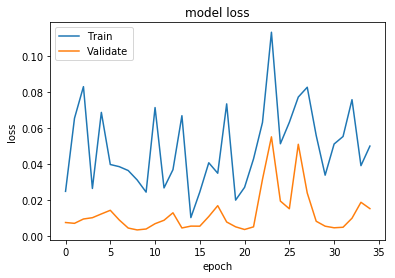

In [53]:
# Plot history for training and validation loss.

plt.plot(history_lstm['loss'])
plt.plot(history_lstm['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

In [22]:
def create_dataset(X, Y, **options):
    """Convert an array of X, Y values into a dataset matrix for and LSTM"""
    
    look_back = options.pop('look_back', None)
    dataX, dataY = [], []
    for i in range(len(X) - look_back - 1):
        a = X[i:(i+look_back)]
        dataX.append(a)
        dataY.append(Y[i + look_back])
    return np.array(dataX), np.array(dataY)

In [55]:
# Show model predictions against input occupancy labels, and input data timestreams


test['LSTM'] = pd.Series(y_pred, index=test.index)

test['Occupancy'].plot(figsize=[20, 10], legend=True)
test['LSTM'].apply(lambda x: x - 1.1).plot(legend=True)

AttributeError: 'numpy.ndarray' object has no attribute 'index'